# User input: 
### Select testcase, control and configuration scenario for the control
---

In [88]:
testcase = 'multizone_office_simple_air' # bestest_air, bestest_hydronic_heat_pump, singlezone_commercial_hydronic, multizone_office_simple_air
control = 'os_c_1a2b_zone_temp_adj_inc_ratch_pre_heat_cool_com'  
# os_c_1a_zone_temp_adj_inc_ratch
# os_c_1b_zone_temp_adj_perform_ratch
# os_c_2a_zone_pre_heat_cool_sim
# os_c_2b_zone_pre_heat_cool_com
# os_c_1a2a_zone_temp_adj_inc_ratch_pre_heat_cool_sim
# os_c_1a2b_zone_temp_adj_inc_ratch_pre_heat_cool_com
# os_c_1b2a_zone_temp_adj_perform_ratch_pre_heat_cool_sim
# os_c_1b2b_zone_temp_adj_perform_ratch_pre_heat_cool_com
# os_c_3_chi_water_temp_reset

boptest_scenario = 'peak_heat' 
control_configuration_scenario = 'default_scenario'

In [89]:
# Define the dictionary with identifiers
identifiers = {
    'bestest_air': 'b1', 
    'bestest_hydronic_heat_pump': 'b2', 
    'singlezone_commercial_hydronic': 'b3', 
    'multizone_office_simple_air': 'b4'
}

# Check the corresponding identifier for the selected testcase
if testcase in identifiers:
    testcase_identifier = identifiers[testcase]
    print(f"The identifier for the testcase '{testcase}' is '{testcase_identifier}'.")
else:
    print(f"The testcase '{testcase}' is not found in the identifiers dictionary.")

The identifier for the testcase 'multizone_office_simple_air' is 'b4'.


# Import modules and functions
---

In [90]:
import math
import os
from pathlib import Path

import sys
# # Define the path to the outer energy_flexibility_kpis directory
current_dir = os.path.dirname(os.path.abspath(''))
project_root = os.path.abspath(os.path.join(current_dir, '../../energy_flexibility_kpis'))
# Add the project root to sys.path
sys.path.insert(0, project_root)

import pandas as pd
import yaml
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import energy_flexibility_kpis.kpi.energy_flexibility.demand_profile_reshaping as demand_profile_reshaping
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_costs_or_savings as demand_response_costs_or_savings
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_emission_or_environmental_impact as demand_response_emission_or_environmental_impact
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_energy_efficiency as demand_response_energy_efficiency
import energy_flexibility_kpis.kpi.energy_flexibility.energy_or_average_power_load_shedding as energy_or_average_power_load_shedding
import energy_flexibility_kpis.kpi.energy_flexibility.energy_storage_capability as energy_storage_capability
import energy_flexibility_kpis.kpi.energy_flexibility.grid_interaction as grid_interaction
import energy_flexibility_kpis.kpi.energy_flexibility.impact_on_ieq as impact_on_ieq
import energy_flexibility_kpis.kpi.energy_flexibility.load_shifting as load_shifting
import energy_flexibility_kpis.kpi.energy_flexibility.peak_power_or_energy_rebound as peak_power_or_energy_rebound
import energy_flexibility_kpis.kpi.energy_flexibility.peak_power_shedding as peak_power_shedding
import energy_flexibility_kpis.kpi.energy_flexibility.valley_filling as valley_filling
from energy_flexibility_kpis.utilities import FileHandler

# How to get the info for a KPI
---

In [91]:
peak_power_or_energy_rebound.PeakPowerRebound.info()

{'name': 'peak power rebound',
 'definition': 'Power demand increase during peak hour after flexible operation (rebound effect). The evaluation window should be set to the rebound period.',
 'unit': 'kW',
 'category': 'EF KPI: Peak Power/Energy Rebound',
 'relevance': 3,
 'stakeholders': ['distribution system operator',
  'transmisssion system operator'],
 'complexity': 1,
 'need_baseline': True,
 'temporal_evaluation_window': 'single event',
 'temporal_resolution': 'unspecified',
 'spatial_resolution': 'single building',
 'doe_flexibility_category': ['load shifting', 'load shedding'],
 'performance_aspect': ['power'],
 'calculation_arguments': [{'name': 'baseline electric power profile',
   'snake_case_name': 'baseline_electric_power_profile',
   'definition': 'A time series data points of electric power demand acquired in baseline operation scenario.',
   'primitive_type': {'name': 'power demand',
    'definition': 'An instantaneous power demand of a entity at a moment.',
    'unit':

# KPI Calculation Function Design Choices
---
1. All KPIs have a `calculate` function whose arguments refer to the variables listed in the [variables sheet](https://docs.google.com/spreadsheets/d/1tSN3PIu-lh9aSiU775-RULTRy2o2owIzV-iwymNXszo/edit#gid=118080661).
2. Every KPIs `calculate` function has positional arguments that must be provided and keyword arguments that are optional. The positional arguments will typically include power and energy profile e.g., `generic_electric_power_profile`, `flexible_electric_power_profile`, e.t.c. In some cases, `timestamps` variable is required e.g. in `energy_or_average_power_load_shedding.AnnualAverageDailyLoadVariation` where `timestamps` variable is needed to infer `hour-of-day` and `day-of-year` variables.
1. Every KPI's `calculate` function has `timestamps`, `evaluation_start_timestamp` and `evaluation_end_timestamp` as optional arguments so that the user can at any time supply the full power or energy profile and only need to control the `evaluation_start_timestamp` and `evaluation_end_timestamp` variables to consider specific time periods during calculation.
2. `timestamps` can be a datetime series of a timestep series i.e. integers.
3. KPIs that are defined for a building or DER cluster will take in a list of lists for some variables instead of taking in a single list of values
4. Writing all KPIs with the assumption that the input variables are in SI unit and values are reported as such eg. time in seconds, power in kW, energy in kWh.

# Check config file and data directories
---

In [92]:
import os

config_path = os.path.join('..', f'testcase_{testcase}', 'config_analytics.yaml')
#path_to_dataset = os.path.join('..' f'testcase_{testcase}', f'results_{control}', control_configuration_scenario)
testcase_directory = os.path.join('..', f'testcase_{testcase}')

current_dir = os.path.dirname(os.path.abspath(''))
path_to_dataset = os.path.abspath(os.path.join(current_dir, f'testcase_{testcase}/results_{control}/default_scenario'))

print(testcase_directory)

# Validate common/basic inputs from config path

def validate_yaml(data):
    required_keys = [
        'brick_model_file_name',
        'database_file_name',
        'updated_brick_model_file_name', 
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',       
    ]

    for key in required_keys:
        if key not in data:
            config_file_validation = False
            return config_file_validation, f"Key '{key}' is missing in the config file."
        config_file_validation = True
    return config_file_validation,  "Basic inputs from config file are valid."

# Load the YAML file
with open(config_path, 'r') as file:
    config_file_data = yaml.safe_load(file)

# Validate the YAML file
config_file_validation, message = validate_yaml(config_file_data)

# Print the validation result
if config_file_validation:
    print(message)
    # Access the data
    brick_model_file_name = config_file_data['brick_model_file_name']
    database_file_name = config_file_data['database_file_name']
    updated_brick_model_file_name = config_file_data['updated_brick_model_file_name']
    baseline_scenario = config_file_data.get('baseline_scenario', None)
    flexible_scenario = config_file_data.get('flexible_scenario', None)
    evaluation_timestamps = [(
        pd.Timestamp(config_file_data['evaluation_timestamps']['start']),
        pd.Timestamp(config_file_data['evaluation_timestamps']['end'])
    )]

else:
    print(f"Validation failed: {message}")


..\testcase_multizone_office_simple_air
Basic inputs from config file are valid.


# Validating a Dataset
---

### Validating a Brick model

In [93]:
# Define manifest paths (metadata requirements for the KPIs)
manifest_paths = {'average demand decrease index':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_decrease_index.ttl',
                  'average demand decrease':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_decrease.ttl',
                  'average demand decrease intensity':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_decrease_intensity.ttl',
                  'average demand increase index':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_increase_index.ttl',
                  'average demand increase':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_increase.ttl',
                  'average demand increase intensity':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_increase_intensity.ttl',
                  'average power rebound index':'validation_buildingMOTIF/manifests_kpis/manifest_average_power_rebound_index.ttl',
                  'average power rebound':'validation_buildingMOTIF/manifests_kpis/manifest_average_power_rebound.ttl',
                  'energy savings of demand response':'validation_buildingMOTIF/manifests_kpis/manifest_energy_savings_of_demand_response.ttl',
                  'flexibility savings index':'validation_buildingMOTIF/manifests_kpis/manifest_flexibility_savings_index.ttl',
                  'net building consumption change percentage':'validation_buildingMOTIF/manifests_kpis/manifest_net_building_consumption_change_percentage.ttl',
                  'peak power reduction':'validation_buildingMOTIF/manifests_kpis/manifest_peak_power_reduction.ttl'
                  }


In [94]:
from validation_buildingMOTIF.kpis_validation import ValidationInterface

# Initialize validation interface
validator = ValidationInterface(os.path.join(testcase_directory,brick_model_file_name), manifest_paths)

# Run validation
suitable_kpis_brick = []
suitable_kpis_brick = validator.validate()
suitable_kpis_brick = [list(d)[0] for d in suitable_kpis_brick]

print('Suitable KPIs according to metadata in the Brick model',suitable_kpis_brick)

KeyboardInterrupt: 

In [ ]:
# Define the dictionary of KPIs and their required keys
kpi_required_keys = {
    'average demand decrease index':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 

    ],
    'average demand decrease':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 
    ],
    'average demand decrease intensity':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 
    ],
    'average demand increase index':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'shift_window',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 
    ],
    'average demand increase':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'shift_window',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 
    ],
    'average demand increase intensity':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'shift_window',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 
    ],
    'average power rebound index':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'rebound_window',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 
    ],
    'average power rebound':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'rebound_window',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 
    ],
    'average power rebound intensity':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'rebound_window',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 
    ],
    'energy savings of demand response':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'timestamp_identifier',

    ],
    'flexibility savings index':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 
    ],
    'net building consumption change percentage':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'timestamp_identifier',

    ],
    'peak power reduction':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'timestamp_identifier',

        'occ_file_name',
        'occ_identifier',
        'occ_min_threshold' 
    ],
}
def validate_yaml(data, kpi_name):
    # Get the required keys for the specified KPI
    required_keys = kpi_required_keys.get(kpi_name, [])
    
    # Collect missing metadata for the KPI
    missing_metadata = [key for key in required_keys if key not in data]

    if not missing_metadata:
        return True, f"KPI '{kpi_name}' is valid.", missing_metadata
    else:
        return False, f"KPI '{kpi_name}' is missing metadata: {', '.join(missing_metadata)}", missing_metadata

# Load the YAML file
with open(config_path, 'r') as file:
    config_file_data = yaml.safe_load(file)

# Specify the list of KPIs you want to validate
kpis_to_validate = list(kpi_required_keys.keys())

# Create a table to display results
table = PrettyTable()
table.field_names = ["KPI", "Config file validation result"]

# Collect missing metadata for each KPI
missing_metadata_results = {}
unique_missing_metadata = set()
suitable_kpis_config_file = []

# Validate the YAML file for each specified KPI
for kpi_to_validate in kpis_to_validate:
    is_valid, message, missing_metadata = validate_yaml(config_file_data, kpi_to_validate)

    # Add row to the table
    table.add_row([kpi_to_validate, is_valid])
    
    unique_missing_metadata.update(missing_metadata)

    if is_valid:
        suitable_kpis_config_file.append(kpi_to_validate)
    else:
        missing_metadata_results[kpi_to_validate] = message

# Print the table
print(table)
print('Suitable KPIs according to metadata in the config file',suitable_kpis_config_file)
# Print missing metadata for each KPI
for kpi_name, missing_metadata_message in missing_metadata_results.items():
    print(missing_metadata_message)
print ('Missing unique metadata in the config file', unique_missing_metadata)


+--------------------------------------------+-------------------------------+
|                    KPI                     | Config file validation result |
+--------------------------------------------+-------------------------------+
|       average demand decrease index        |              True             |
|          average demand decrease           |              True             |
|     average demand decrease intensity      |              True             |
|       average demand increase index        |              True             |
|          average demand increase           |              True             |
|     average demand increase intensity      |              True             |
|        average power rebound index         |              True             |
|           average power rebound            |              True             |
|      average power rebound intensity       |              True             |
|     energy savings of demand response      |      

### Combined validation result

In [ ]:
suitable_kpis = list(set(suitable_kpis_brick) & set(suitable_kpis_config_file))
print ('Suitable KPIs according to metadata in the Brick model and config file', suitable_kpis)

Suitable KPIs according to metadata in the Brick model and config file ['flexibility savings index', 'average demand decrease', 'average power rebound', 'average demand increase', 'average power rebound index', 'average demand decrease index', 'average demand increase intensity', 'peak power reduction', 'average demand decrease intensity', 'energy savings of demand response', 'average demand increase index', 'net building consumption change percentage']


# Importing a Dataset
---

In [ ]:
all_available_metadata = set(key for kpi_keys in kpi_required_keys.values() for key in kpi_keys) - unique_missing_metadata
print (all_available_metadata)

# Load the YAML file
with open(config_path, 'r') as file:
    config_file_data = yaml.safe_load(file)

# Fetch data only for keys in all_required_keys
filtered_config_file_data = {key: config_file_data[key] for key in all_available_metadata if key in config_file_data}

# Access the filtered data
price_signal_file_name = filtered_config_file_data.get('price_signal_file_name', None)
timestamp_identifier = filtered_config_file_data.get('timestamp_identifier', None)
price_signal_identifier = filtered_config_file_data.get('price_signal_identifier', None)
shift_window = filtered_config_file_data.get('shift_window', None)
rebound_window = filtered_config_file_data.get('rebound_window', None)


occ_file_name = filtered_config_file_data.get('occ_file_name', None)
occ_identifier = filtered_config_file_data.get('occ_identifier', None)
occ_min_threshold = filtered_config_file_data.get('occ_min_threshold', None)

thermal_price_identifier = config_file_data.get('thermal_price_identifier', None)


{'price_signal_file_name', 'baseline_scenario', 'evaluation_timestamps', 'occ_identifier', 'occ_file_name', 'flexible_scenario', 'price_signal_identifier', 'shift_window', 'rebound_window', 'occ_min_threshold', 'timestamp_identifier'}


### Edit Brick model 
Include references to csv files per datapoint

In [ ]:
import duckdb
import pandas as pd
import glob
import rdflib
from pathlib import Path
from rdflib import Namespace, Literal, Graph, BNode
from rdflib import RDF, RDFS, BRICK

A = RDF.type
REF = Namespace("https://brickschema.org/schema/Brick/ref#")
BLDG = Namespace("urn:boptest_example/")

model = Graph()
model.bind("ref", REF)
model.bind("rdfs", RDFS)
model.bind("brick", BRICK)
model.bind("bldg", BLDG)

# load base model from file
model.parse(os.path.join(testcase_directory,brick_model_file_name))

db = duckdb.connect(database_file_name)

print(os.listdir(path_to_dataset))

# load in the CSV files
for filename in glob.glob(os.path.join(path_to_dataset, "*dataset.csv")):
    print(filename)
    table_name = Path(filename).name.split('.')[0]
    df = pd.read_csv(filename, skiprows=[1])
    df['Timestamp'] = pd.to_datetime(df.pop(timestamp_identifier))
    # remove first row -- it is the unit declarations
    df.drop(1, axis=0)
    db.execute(f"DROP TABLE IF EXISTS {table_name}")

    db.execute(f"CREATE TABLE {table_name} AS SELECT * FROM df")

    # add the annotation to the Brick model
    for pointlabel in df.columns:
        point = list(model.query(f'SELECT ?point WHERE {{ ?point ref:hasExternalReference ?ref . ?ref ref:hasTimeseriesId "{pointlabel}" }}'))

        if not point:
            continue
        point = point[0][0]
        reference = BNode()
        model.add((point, REF.hasExternalReference, reference))
        model.add((reference, A, REF.TimeseriesReference))
        model.add((reference, REF.hasTimeseriesId, Literal(pointlabel)))
        model.add((reference, REF.onTable, Literal(table_name)))
        model.add((reference, REF.storedAt, Literal("data.db")))
model.serialize(os.path.join(testcase_directory,updated_brick_model_file_name))
# save data to duckdb
db.commit()

['B3_FixSc1_demand.png', 'B3_FixSc1_demand_temperature.png', 'B3_FixSc1_temperature.png', 'baseline.csv', 'baseline_dataset.csv', 'baseline_powerData.csv', 'baseline_tempData.csv', 'baseline_tempData_dataset.csv', 'flexible_dataset.csv', 'flexible_powerData.csv', 'flexible_tempData.csv', 'flexible_tempData_dataset.csv', 'kpis_con.csv', 'plot_results.ipynb', 'scheduleData.csv', 'scheduleData_dataset.csv']
c:\Users\Flavinha\DFLEXLIBS\DFLEXLIBS\examples\boptest\testcase_singlezone_commercial_hydronic\results_os_c_1a2b_zone_temp_adj_inc_ratch_pre_heat_cool_com\default_scenario\baseline_dataset.csv
c:\Users\Flavinha\DFLEXLIBS\DFLEXLIBS\examples\boptest\testcase_singlezone_commercial_hydronic\results_os_c_1a2b_zone_temp_adj_inc_ratch_pre_heat_cool_com\default_scenario\baseline_tempData_dataset.csv
c:\Users\Flavinha\DFLEXLIBS\DFLEXLIBS\examples\boptest\testcase_singlezone_commercial_hydronic\results_os_c_1a2b_zone_temp_adj_inc_ratch_pre_heat_cool_com\default_scenario\flexible_dataset.csv
c:\U

# Map Dataset to EFONT Variables
---

In [ ]:
# Parse graph
g = rdflib.Graph()
g.parse(os.path.join(testcase_directory,updated_brick_model_file_name))
# Establish a connection to DuckDB database
db = duckdb.connect(database=database_file_name)

query = f"""
PREFIX brick: <https://brickschema.org/schema/Brick#>
SELECT ?area WHERE {{
    ?building a brick:Building ;
    brick:area [brick:value ?area] .

}}"""

for row in g.query(query):
    print(row)
    floor_area = (float(row[0]))

print(floor_area)

(rdflib.term.Literal('8500.0', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#float')),)
8500.0


In [ ]:
# Parse graph
g = rdflib.Graph()
g.parse(os.path.join(testcase_directory,updated_brick_model_file_name))
# Establish a connection to DuckDB database
db = duckdb.connect(database=database_file_name)

scenarios = {
    baseline_scenario: 'baseline_',
    flexible_scenario: 'flexible_'
}

data_dict = {}

for scenario, column_name in scenarios.items():
    query = f"""
    PREFIX ref: <https://brickschema.org/schema/Brick/ref#>
    SELECT ?power_point WHERE {{
        ?point a brick:Electric_Power_Sensor ;
            ref:hasExternalReference ?ref .
        ?ref ref:onTable "{scenario}" ;
            ref:hasTimeseriesId ?power_point .

    }}"""

    # Convert the rows to a dictionary for DataFrame creation
    for row in g.query(query):
        print(row)
        power_point = row [0]
        duck_query_label = f"SELECT Timestamp, {power_point} FROM {scenario}"
        
        res_label = db.execute(duck_query_label)
        timestamp_values_label = res_label.fetchall()
        #for row in timestamp_values_label[:5]:
        #    print(row)

        # Extract timestamps and values from the rows
        timestamps_label, values_label = zip(*timestamp_values_label)

        # Resample the values
        values_series_label = pd.Series(values_label, index=timestamps_label)
        
        resampled_series_label = values_series_label.resample('15T').mean()/1000

        # TO DO: add unit in the graph, query it and depending on the unit convert the values (eg from W to kW)

        # Create columns for label and sensor data for each scenario
        if f'{column_name}electric_power_profile' in data_dict:
            data_dict[f'{column_name}electric_power_profile'] += resampled_series_label
        else:
            data_dict[f'{column_name}electric_power_profile'] = resampled_series_label


# Create a DataFrame from the data dictionary
data = pd.DataFrame(data_dict)

# Reset the index to convert the timestamp index to a column
data = data.rename_axis('timestamp').reset_index()

# Print the DataFrame
display(data.head(5))
display(data.tail(10))



(rdflib.term.Literal('ahu_reaPFanRet_y'),)
(rdflib.term.Literal('ahu_reaPFanSup_y'),)


C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3400882994.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_series_label = values_series_label.resample('15T').mean()/1000


(rdflib.term.Literal('reaPEle_y'),)
(rdflib.term.Literal('reaPFan_y'),)
(rdflib.term.Literal('reaPPum_y'),)
(rdflib.term.Literal('ahu_reaPFanRet_y'),)
(rdflib.term.Literal('ahu_reaPFanSup_y'),)
(rdflib.term.Literal('reaPEle_y'),)
(rdflib.term.Literal('reaPFan_y'),)
(rdflib.term.Literal('reaPPum_y'),)


,timestamp,baseline_electric_power_profile,flexible_electric_power_profile
0,1970-01-09 00:00:00,0.435272,0.435273
1,1970-01-09 00:15:00,0.435551,0.435548
2,1970-01-09 00:30:00,0.435632,0.435635
3,1970-01-09 00:45:00,0.436010,0.436006
4,1970-01-09 01:00:00,0.436015,0.436017


,timestamp,baseline_electric_power_profile,flexible_electric_power_profile
1335,1970-01-22 21:45:00,0.447836,0.448224
1336,1970-01-22 22:00:00,0.448101,0.448514
1337,1970-01-22 22:15:00,0.448210,0.448616
1338,1970-01-22 22:30:00,0.448471,0.448858
1339,1970-01-22 22:45:00,0.448702,0.449109
1340,1970-01-22 23:00:00,0.449025,0.449410
1341,1970-01-22 23:15:00,0.449330,0.449716
1342,1970-01-22 23:30:00,0.449584,0.449974
1343,1970-01-22 23:45:00,0.449872,0.450247
1344,1970-01-23 00:00:00,0.449990,0.450377


In [ ]:
# Parse graph
g = rdflib.Graph()
g.parse(os.path.join(testcase_directory,updated_brick_model_file_name))
# Establish a connection to DuckDB database
db = duckdb.connect(database=database_file_name)

scenarios = {
    baseline_scenario: 'baseline_',
    flexible_scenario: 'flexible_'
}

data_dict = {}

for dataset_scenario, column_name in scenarios.items():
    query = f"""
    PREFIX ref: <https://brickschema.org/schema/Brick/ref#>
    SELECT ?power_point WHERE {{
        ?point a brick:Thermal_Power_Sensor ;
            ref:hasExternalReference ?ref .
        ?ref ref:onTable "{dataset_scenario}" ;
            ref:hasTimeseriesId ?power_point .

    }}"""

    # Convert the rows to a dictionary for DataFrame creation
    for row in g.query(query):
        print(row)
        power_point = row [0]
        duck_query_label = f"SELECT Timestamp, {power_point} FROM {dataset_scenario}"
        
        res_label = db.execute(duck_query_label)
        timestamp_values_label = res_label.fetchall()
        #for row in timestamp_values_label[:5]:
        #    print(row)

        # Extract timestamps and values from the rows
        timestamps_label, values_label = zip(*timestamp_values_label)

        # Resample the values
        values_series_label = pd.Series(values_label, index=timestamps_label)
        
        resampled_series_label = values_series_label.resample('15T').mean()/1000

        # TO DO: add unit in the graph, query it and depending on the unit convert the values (eg from W to kW)

        # Create columns for label and sensor data for each scenario
        if f'{column_name}thermal_power_profile' in data_dict:
            data_dict[f'{column_name}thermal_power_profile'] += resampled_series_label
        else:
            data_dict[f'{column_name}thermal_power_profile'] = resampled_series_label


# Create a DataFrame from the data dictionary
new_data = pd.DataFrame(data_dict)

# Reset the index to convert the timestamp index to a column
new_data = new_data.rename_axis('timestamp').reset_index()

display(new_data.head(5))

thermal_column = 'baseline_thermal_power_profile'

if thermal_column in new_data.columns:

    data = pd.merge(data, new_data[['timestamp', 'baseline_thermal_power_profile', 'flexible_thermal_power_profile']], on='timestamp', how='left')

    data['timestamp'] = pd.to_datetime(data['timestamp'])

    display(data.head(5))

electric_column = 'baseline_electric_power_profile'

if electric_column in data.columns and thermal_column in data.columns:
    data['baseline_power_profile'] = data[electric_column] + data[thermal_column]

else:
    data['baseline_power_profile'] = data[electric_column]

electric_column_flex = 'flexible_electric_power_profile'
thermal_column_flex = 'flexible_thermal_power_profile'

if electric_column_flex in data.columns and thermal_column_flex in data.columns:
    data['flexible_power_profile'] = data[electric_column_flex] + data[thermal_column_flex]

else:
    data['flexible_power_profile'] = data[electric_column_flex] 

# Print the DataFrameaa
display(data.head(5))
display(data.tail(10))


(rdflib.term.Literal('reaQHea_y'),)
(rdflib.term.Literal('reaQHea_y'),)


C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\2216342606.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_series_label = values_series_label.resample('15T').mean()/1000


,timestamp,baseline_thermal_power_profile,flexible_thermal_power_profile
0,1970-01-09 00:00:00,31.222881,31.224336
1,1970-01-09 00:15:00,31.575014,31.571266
2,1970-01-09 00:30:00,31.675215,31.680059
3,1970-01-09 00:45:00,32.152734,32.148246
4,1970-01-09 01:00:00,32.156895,32.159728


,timestamp,baseline_electric_power_profile,flexible_electric_power_profile,baseline_thermal_power_profile,flexible_thermal_power_profile
0,1970-01-09 00:00:00,0.435272,0.435273,31.222881,31.224336
1,1970-01-09 00:15:00,0.435551,0.435548,31.575014,31.571266
2,1970-01-09 00:30:00,0.435632,0.435635,31.675215,31.680059
3,1970-01-09 00:45:00,0.436010,0.436006,32.152734,32.148246
4,1970-01-09 01:00:00,0.436015,0.436017,32.156895,32.159728


,timestamp,baseline_electric_power_profile,flexible_electric_power_profile,baseline_thermal_power_profile,flexible_thermal_power_profile,baseline_power_profile,flexible_power_profile
0,1970-01-09 00:00:00,0.435272,0.435273,31.222881,31.224336,31.658153,31.659609
1,1970-01-09 00:15:00,0.435551,0.435548,31.575014,31.571266,32.010565,32.006814
2,1970-01-09 00:30:00,0.435632,0.435635,31.675215,31.680059,32.110846,32.115694
3,1970-01-09 00:45:00,0.436010,0.436006,32.152734,32.148246,32.588744,32.584252
4,1970-01-09 01:00:00,0.436015,0.436017,32.156895,32.159728,32.592910,32.595745


,timestamp,baseline_electric_power_profile,flexible_electric_power_profile,baseline_thermal_power_profile,flexible_thermal_power_profile,baseline_power_profile,flexible_power_profile
1335,1970-01-22 21:45:00,0.447836,0.448224,46.760076,47.237823,47.207912,47.686047
1336,1970-01-22 22:00:00,0.448101,0.448514,47.084533,47.594116,47.532633,48.042631
1337,1970-01-22 22:15:00,0.448210,0.448616,47.214076,47.713712,47.662286,48.162327
1338,1970-01-22 22:30:00,0.448471,0.448858,47.535525,48.010587,47.983997,48.459444
1339,1970-01-22 22:45:00,0.448702,0.449109,47.819485,48.319633,48.268187,48.768741
1340,1970-01-22 23:00:00,0.449025,0.449410,48.217837,48.690887,48.666862,49.140297
1341,1970-01-22 23:15:00,0.449330,0.449716,48.593597,49.068983,49.042927,49.518699
1342,1970-01-22 23:30:00,0.449584,0.449974,48.906190,49.385593,49.355775,49.835568
1343,1970-01-22 23:45:00,0.449872,0.450247,49.259852,49.720086,49.709724,50.170333
1344,1970-01-23 00:00:00,0.449990,0.450377,49.404008,49.878682,49.853998,50.329059


### Utility function: price threshold

In [ ]:
def get_price_threshold(price_schedule): 
   
    # Sort the prices in ascending order
    price_schedule.sort()

    # Calculate the index of the third quartile
    n = len(price_schedule)
    k = (3.0 * n - 1) / 4

    # Determine the price threshold as the third quartile
    if k == int(k):
        priceThreshold = price_schedule[int(k) - 1]
    else:
        priceThreshold = (price_schedule[int(k) - 1] + price_schedule[int(k)]) / 2

    return priceThreshold

### Utility function: shed timestamp

In [ ]:
if all(var is not None for var in [price_signal_file_name, timestamp_identifier, price_signal_file_name]):

    # Read the DataFrame from a CSV file
    price_df = pd.read_csv(os.path.join(path_to_dataset,price_signal_file_name))

    # Extract the start and end times from the evaluation timestamp
    start_time, end_time = evaluation_timestamps[0]

    # Filter the DataFrame to include only rows within the specified time range
    price_df[timestamp_identifier] = pd.to_datetime(price_df[timestamp_identifier])
    filtered_price_df = price_df[(price_df[timestamp_identifier] >= start_time) & (price_df[timestamp_identifier] <= end_time)]

    #display(filtered_price_df.head(15))
    price_values = filtered_price_df[price_signal_identifier].tolist()

    #print(price_values)
    price_threshold = get_price_threshold(price_values)
    print('Price threshold', price_threshold)

    # Filter the rows where price_signal is greater than price_threshold
    shed_price_df = filtered_price_df[filtered_price_df[price_signal_identifier] >= price_threshold]

    # Print the DataFrame
    display(shed_price_df.head(15))

    shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])
    unique_dates = shed_price_df[timestamp_identifier].dt.strftime('%Y-%m-%d').unique()

    # Create list of signal timestamps
    pre_shed_signal_timestamps = []

    for day in pd.date_range(start_time, end_time, freq='D'):
        matching_date = str(day.date())
        
        # Check if there are any rows in df where the date matches the current date
        if matching_date in unique_dates:
            group = shed_price_df[shed_price_df[timestamp_identifier].dt.date == day.date()]
            group['time'] = group[timestamp_identifier].dt.strftime('%H:%M:%S')  # Convert to string for comparison
            # Ensure the 'time' column is in datetime format
            group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
            start_time = None

            for index, row in enumerate(group.itertuples()):
                if start_time is None:
                    start_time = row.time
                elif row.time - group['time'].iloc[index - 1] != pd.Timedelta(minutes=1):
                    end_time = group['time'].iloc[index - 1] + pd.Timedelta(minutes=14, seconds=59)
                    pre_shed_signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))
                    start_time = row.time

            if start_time is not None:
                end_time = group['time'].iloc[-1] + pd.Timedelta(minutes=14, seconds=59)
                pre_shed_signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))
    # Display the result
    print(pre_shed_signal_timestamps)

shed_signal_timestamps = []

if pre_shed_signal_timestamps:
    current_start, current_end = pre_shed_signal_timestamps[0]

    for start, end in pre_shed_signal_timestamps[1:]:
        if start <= current_end + pd.Timedelta(seconds=1):
            current_end = max(end, current_end)
        else:
            shed_signal_timestamps.append((current_start, current_end))
            current_start, current_end = start, end

    shed_signal_timestamps.append((current_start, current_end))

    print(shed_signal_timestamps)



Price threshold 0.05093


,time,PriceElectricPowerConstant,PriceElectricPowerDynamic,PriceElectricPowerHighlyDynamic,PriceDistrictHeatingPower,pAtm,lon,lat,TDewPoi,HDirNor,...,InternalGainsCon[1],InternalGainsLat[1],LowerSetp[1],UpperSetp[1],UpperCO2[1],EmissionsElectricPower,EmissionsDistrictHeatingPower,EmissionsGasPower,EmissionsBiomassPower,EmissionsSolarThermalPower
28,1970-01-09 07:00:00,0.04281,0.05253,0.05519,0.0828,101325,0.221133,0.970927,271.650000,0.0,...,18191.99920,9095.99960,288.15,303.15,800,0.209,0.1163,0.2,0,0
29,1970-01-09 07:15:00,0.04281,0.05253,0.05519,0.0828,101325,0.221133,0.970927,271.582422,0.0,...,18479.99960,9239.99980,294.15,303.15,800,0.209,0.1163,0.2,0,0
30,1970-01-09 07:30:00,0.04281,0.05253,0.05519,0.0828,101325,0.221133,0.970927,271.544792,0.0,...,20387.99970,10193.99985,294.15,303.15,800,0.209,0.1163,0.2,0,0
31,1970-01-09 07:45:00,0.04281,0.05253,0.05519,0.0828,101325,0.221133,0.970927,271.509766,0.0,...,20908.80150,10454.39990,294.15,303.15,800,0.209,0.1163,0.2,0,0
32,1970-01-09 08:00:00,0.04281,0.05253,0.05491,0.0828,101325,0.221133,0.970927,271.450000,0.0,...,21840.00030,10920.00015,294.15,303.15,800,0.209,0.1163,0.2,0,0
33,1970-01-09 08:15:00,0.04281,0.05253,0.05491,0.0828,101325,0.221133,0.970927,271.310156,0.0,...,22992.00105,11496.00010,294.15,303.15,800,0.209,0.1163,0.2,0,0
34,1970-01-09 08:30:00,0.04281,0.05253,0.05491,0.0828,101325,0.221133,0.970927,271.100000,0.0,...,23808.00020,11904.00010,294.15,303.15,800,0.209,0.1163,0.2,0,0
35,1970-01-09 08:45:00,0.04281,0.05253,0.05491,0.0828,101325,0.221133,0.970927,270.889844,0.0,...,24144.00010,12072.00005,294.15,303.15,800,0.209,0.1163,0.2,0,0
36,1970-01-09 09:00:00,0.04281,0.05253,0.05733,0.0828,101325,0.221133,0.970927,270.750000,0.0,...,24335.99980,12167.99990,294.15,303.15,800,0.209,0.1163,0.2,0,0
37,1970-01-09 09:15:00,0.04281,0.05253,0.05733,0.0828,101325,0.221133,0.970927,270.703906,0.0,...,24815.99990,12407.99995,294.15,303.15,800,0.209,0.1163,0.2,0,0


[(Timestamp('1970-01-09 07:00:00'), Timestamp('1970-01-09 07:14:59')), (Timestamp('1970-01-09 07:15:00'), Timestamp('1970-01-09 07:29:59')), (Timestamp('1970-01-09 07:30:00'), Timestamp('1970-01-09 07:44:59')), (Timestamp('1970-01-09 07:45:00'), Timestamp('1970-01-09 07:59:59')), (Timestamp('1970-01-09 08:00:00'), Timestamp('1970-01-09 08:14:59')), (Timestamp('1970-01-09 08:15:00'), Timestamp('1970-01-09 08:29:59')), (Timestamp('1970-01-09 08:30:00'), Timestamp('1970-01-09 08:44:59')), (Timestamp('1970-01-09 08:45:00'), Timestamp('1970-01-09 08:59:59')), (Timestamp('1970-01-09 09:00:00'), Timestamp('1970-01-09 09:14:59')), (Timestamp('1970-01-09 09:15:00'), Timestamp('1970-01-09 09:29:59')), (Timestamp('1970-01-09 09:30:00'), Timestamp('1970-01-09 09:44:59')), (Timestamp('1970-01-09 09:45:00'), Timestamp('1970-01-09 09:59:59')), (Timestamp('1970-01-09 10:00:00'), Timestamp('1970-01-09 10:14:59')), (Timestamp('1970-01-09 10:15:00'), Timestamp('1970-01-09 10:29:59')), (Timestamp('1970-01

C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3502575797.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])
C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3502575797.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group[timestamp_identifier].dt.strftime('%H:%M:%S')  # Convert to string for comparison
C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3502575797.py:40: SettingWithCopyW


[(Timestamp('1970-01-09 07:00:00'), Timestamp('1970-01-09 11:59:59')), (Timestamp('1970-01-09 17:00:00'), Timestamp('1970-01-09 18:59:59')), (Timestamp('1970-01-10 07:00:00'), Timestamp('1970-01-10 11:59:59')), (Timestamp('1970-01-10 17:00:00'), Timestamp('1970-01-10 18:59:59')), (Timestamp('1970-01-11 07:00:00'), Timestamp('1970-01-11 11:59:59')), (Timestamp('1970-01-11 17:00:00'), Timestamp('1970-01-11 18:59:59')), (Timestamp('1970-01-12 07:00:00'), Timestamp('1970-01-12 11:59:59')), (Timestamp('1970-01-12 17:00:00'), Timestamp('1970-01-12 18:59:59')), (Timestamp('1970-01-13 07:00:00'), Timestamp('1970-01-13 11:59:59')), (Timestamp('1970-01-13 17:00:00'), Timestamp('1970-01-13 18:59:59')), (Timestamp('1970-01-14 07:00:00'), Timestamp('1970-01-14 11:59:59')), (Timestamp('1970-01-14 17:00:00'), Timestamp('1970-01-14 18:59:59')), (Timestamp('1970-01-15 07:00:00'), Timestamp('1970-01-15 11:59:59')), (Timestamp('1970-01-15 17:00:00'), Timestamp('1970-01-15 18:59:59')), (Timestamp('1970-0

### Utility function: shift timestamp

In [ ]:
if all(var is not None for var in [occ_file_name, timestamp_identifier, occ_min_threshold]):

    # Read the DataFrame from a CSV file
    occ_df = pd.read_csv(os.path.join(path_to_dataset,occ_file_name))

    # Extract the start and end times from the evaluation timestamp
    start_time, end_time = evaluation_timestamps[0]
    print(start_time, end_time)

    # Filter the DataFrame to include only rows within the specified time range

    occ_df[timestamp_identifier] = pd.to_datetime(occ_df[timestamp_identifier])
    filtered_occ_df = occ_df[(occ_df[timestamp_identifier] >= start_time) & (occ_df[timestamp_identifier] <= end_time)]
    display(filtered_occ_df.tail(15))

    # Resample the filtered DataFrame to 15-minute intervals
    filtered_occ_df.set_index(timestamp_identifier, inplace=True)
    resampled_occ_df = filtered_occ_df.resample('15T').mean().reset_index()

    occ_values = resampled_occ_df[occ_identifier].tolist()


    occ_period_df = resampled_occ_df[resampled_occ_df[occ_identifier] > occ_min_threshold]

    # Print the DataFrame
    display(occ_period_df.tail(15))


    occ_period_df[timestamp_identifier] = pd.to_datetime(occ_period_df[timestamp_identifier])

1970-01-09 00:00:00 1970-01-22 23:59:59


,time,oveTZonSet_u,reaTZon_y
40305,1970-01-22 23:52:30,288.15,288.149712
40306,1970-01-22 23:53:00,288.15,288.149715
40307,1970-01-22 23:53:30,288.15,288.149718
40308,1970-01-22 23:54:00,288.15,288.149721
40309,1970-01-22 23:54:30,288.15,288.149723
40310,1970-01-22 23:55:00,288.15,288.149726
40311,1970-01-22 23:55:30,288.15,288.149728
40312,1970-01-22 23:56:00,288.15,288.149730
40313,1970-01-22 23:56:30,288.15,288.149732
40314,1970-01-22 23:57:00,288.15,288.149733


C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\1027616094.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_occ_df = filtered_occ_df.resample('15T').mean().reset_index()


,time,oveTZonSet_u,reaTZon_y
1118,1970-01-20 15:30:00,294.15,294.146289
1119,1970-01-20 15:45:00,294.15,294.148197
1120,1970-01-20 16:00:00,294.15,294.148154
1121,1970-01-20 16:15:00,294.15,294.145723
1122,1970-01-20 16:30:00,294.15,294.147687
1123,1970-01-20 16:45:00,294.15,294.148987
1124,1970-01-20 17:00:00,294.15,294.149072
1125,1970-01-20 17:15:00,294.15,294.148880
1126,1970-01-20 17:30:00,294.15,294.149186
1127,1970-01-20 17:45:00,294.15,294.149416


C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\1027616094.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_period_df[timestamp_identifier] = pd.to_datetime(occ_period_df[timestamp_identifier])


In [ ]:
import pandas as pd

# Assuming price_df is a DataFrame with a 'price' column and occ_df is a DataFrame with an 'occ' column

def check_future_condition(price, occ, price_threshold):
    for i in range(len(price)):
        # Check if both price and occ are greater than their thresholds
        if price[i] > price_threshold and occ[i] > 15 + 273.15:
            # Check if all the previous elements of occ are less than or equal to min and that price is greater than threshold 
            for j in range(i):
                if occ[j] <=  15 + 273.15 and price[j] > price_threshold:
                    return False
            # If no previous element violates the condition, return True
            return True
    # If no element satisfies the condition, return False
    return False


shift_df = []

start_time, end_time = evaluation_timestamps[0]


filtered_price_df = price_df.loc[(price_df[timestamp_identifier] >= start_time) & (price_df[timestamp_identifier] <= end_time)]

filtered_occ_df = occ_df.loc[(occ_df[timestamp_identifier] >= start_time) & (occ_df[timestamp_identifier] <= end_time)]

for i in range(len(filtered_price_df) - 3):
    current_condition = filtered_price_df[price_signal_identifier][i] < price_threshold
    future_hours_conditions = check_future_condition(
        filtered_price_df[price_signal_identifier].iloc[i+1:i+4*3+1].tolist(),
        filtered_occ_df[occ_identifier].iloc[i+1:i+4*3+1].tolist(),
        price_threshold
    )
    if current_condition and future_hours_conditions:
        shift_df.append(i)

# Create a new DataFrame with only the selected indices from price_df
shift_df = filtered_price_df.iloc[shift_df]

# Print or use the result_df as needed
display(shift_df.head(5))


shift_df[timestamp_identifier] = pd.to_datetime(shift_df[timestamp_identifier])
unique_dates = shift_df[timestamp_identifier].dt.strftime('%Y-%m-%d').unique()

# Create list of signal timestamps
pre_shift_signal_timestamps = []

for day in pd.date_range(start_time, end_time, freq='D'):
    matching_date = str(day.date())
    
    # Check if there are any rows in df where the date matches the current date
    if matching_date in unique_dates:
        group = shift_df[shift_df[timestamp_identifier].dt.date == day.date()]
        group['time'] = group[timestamp_identifier].dt.strftime('%H:%M:%S')  # Convert to string for comparison
        # Ensure the 'time' column is in datetime format
        group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
        start_time = None

        for index, row in enumerate(group.itertuples()):
            if start_time is None:
                start_time = row.time
            elif row.time - group['time'].iloc[index - 1] != pd.Timedelta(minutes=1):
                end_time = group['time'].iloc[index - 1] + pd.Timedelta(minutes=14, seconds=59)
                pre_shift_signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))
                start_time = row.time

        if start_time is not None:
            end_time = group['time'].iloc[-1] + pd.Timedelta(minutes=14, seconds=59)
            pre_shift_signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))

# Display the result
print(pre_shift_signal_timestamps)


shift_signal_timestamps = []


if pre_shift_signal_timestamps:
    current_start, current_end = pre_shift_signal_timestamps[0]

    for start, end in pre_shift_signal_timestamps[1:]:
        if start <= current_end + pd.Timedelta(seconds=1):
            current_end = max(end, current_end)
        else:
            shift_signal_timestamps.append((current_start, current_end))
            current_start, current_end = start, end

    shift_signal_timestamps.append((current_start, current_end))

    print(shift_signal_timestamps)

,time,PriceElectricPowerConstant,PriceElectricPowerDynamic,PriceElectricPowerHighlyDynamic,PriceDistrictHeatingPower,pAtm,lon,lat,TDewPoi,HDirNor,...,InternalGainsCon[1],InternalGainsLat[1],LowerSetp[1],UpperSetp[1],UpperCO2[1],EmissionsElectricPower,EmissionsDistrictHeatingPower,EmissionsGasPower,EmissionsBiomassPower,EmissionsSolarThermalPower
880,1970-01-18 04:00:00,0.04281,0.03857,0.03608,0.0828,101325,0.221133,0.970927,272.25000,0.0,...,358.153833,179.076920,288.15,303.15,800,0.209,0.1163,0.2,0,0
881,1970-01-18 04:15:00,0.04281,0.03857,0.03608,0.0828,101325,0.221133,0.970927,272.23125,0.0,...,402.461545,201.230776,288.15,303.15,800,0.209,0.1163,0.2,0,0
882,1970-01-18 04:30:00,0.04281,0.03857,0.03608,0.0828,101325,0.221133,0.970927,272.25000,0.0,...,428.307690,214.153845,288.15,303.15,800,0.209,0.1163,0.2,0,0
883,1970-01-18 04:45:00,0.04281,0.03857,0.03608,0.0828,101325,0.221133,0.970927,272.26875,0.0,...,417.230788,208.615389,288.15,303.15,800,0.209,0.1163,0.2,0,0
884,1970-01-18 05:00:00,0.04281,0.03857,0.04002,0.0828,101325,0.221133,0.970927,272.25000,0.0,...,406.153842,203.076917,288.15,303.15,800,0.209,0.1163,0.2,0,0


[(Timestamp('1970-01-18 04:00:00'), Timestamp('1970-01-18 04:14:59')), (Timestamp('1970-01-18 04:15:00'), Timestamp('1970-01-18 04:29:59')), (Timestamp('1970-01-18 04:30:00'), Timestamp('1970-01-18 04:44:59')), (Timestamp('1970-01-18 04:45:00'), Timestamp('1970-01-18 04:59:59')), (Timestamp('1970-01-18 05:00:00'), Timestamp('1970-01-18 05:14:59')), (Timestamp('1970-01-18 05:15:00'), Timestamp('1970-01-18 05:29:59')), (Timestamp('1970-01-18 05:30:00'), Timestamp('1970-01-18 05:44:59')), (Timestamp('1970-01-18 05:45:00'), Timestamp('1970-01-18 05:59:59')), (Timestamp('1970-01-18 06:00:00'), Timestamp('1970-01-18 06:14:59')), (Timestamp('1970-01-18 06:15:00'), Timestamp('1970-01-18 06:29:59')), (Timestamp('1970-01-18 06:30:00'), Timestamp('1970-01-18 06:44:59')), (Timestamp('1970-01-18 06:45:00'), Timestamp('1970-01-18 06:59:59')), (Timestamp('1970-01-18 14:00:00'), Timestamp('1970-01-18 14:14:59')), (Timestamp('1970-01-18 14:15:00'), Timestamp('1970-01-18 14:29:59')), (Timestamp('1970-01

C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3855228448.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_df[timestamp_identifier] = pd.to_datetime(shift_df[timestamp_identifier])
C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3855228448.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group[timestamp_identifier].dt.strftime('%H:%M:%S')  # Convert to string for comparison
C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3855228448.py:59: SettingWithCopyWarning: 
A

### Utility function: rebound timestamp

In [ ]:
from datetime import timedelta
if all(var is not None for var in [rebound_window]):
    rebound_signal_timestamps = []

    for start, end in shed_signal_timestamps:
        new_start = end + timedelta(seconds=1)
        new_end = end + timedelta(hours=rebound_window)
        rebound_signal_timestamps.append((new_start, new_end))

    print(rebound_signal_timestamps)

[(Timestamp('1970-01-09 12:00:00'), Timestamp('1970-01-09 13:59:59')), (Timestamp('1970-01-09 19:00:00'), Timestamp('1970-01-09 20:59:59')), (Timestamp('1970-01-10 12:00:00'), Timestamp('1970-01-10 13:59:59')), (Timestamp('1970-01-10 19:00:00'), Timestamp('1970-01-10 20:59:59')), (Timestamp('1970-01-11 12:00:00'), Timestamp('1970-01-11 13:59:59')), (Timestamp('1970-01-11 19:00:00'), Timestamp('1970-01-11 20:59:59')), (Timestamp('1970-01-12 12:00:00'), Timestamp('1970-01-12 13:59:59')), (Timestamp('1970-01-12 19:00:00'), Timestamp('1970-01-12 20:59:59')), (Timestamp('1970-01-13 12:00:00'), Timestamp('1970-01-13 13:59:59')), (Timestamp('1970-01-13 19:00:00'), Timestamp('1970-01-13 20:59:59')), (Timestamp('1970-01-14 12:00:00'), Timestamp('1970-01-14 13:59:59')), (Timestamp('1970-01-14 19:00:00'), Timestamp('1970-01-14 20:59:59')), (Timestamp('1970-01-15 12:00:00'), Timestamp('1970-01-15 13:59:59')), (Timestamp('1970-01-15 19:00:00'), Timestamp('1970-01-15 20:59:59')), (Timestamp('1970-01

### Utility function: cost profile

In [ ]:
if all(var is not None for var in [price_signal_file_name, timestamp_identifier, rebound_window]):
    
    # Reset the index to convert the timestamp index to a column
    filtered_price_forCost_df = filtered_price_df.rename(columns={timestamp_identifier: 'timestamp'})
    

    if thermal_price_identifier in filtered_price_forCost_df.columns:
        filtered_price_forCost_df = filtered_price_forCost_df[['timestamp', price_signal_identifier, thermal_price_identifier]].copy()
    else:
        filtered_price_forCost_df = filtered_price_forCost_df[['timestamp', price_signal_identifier]].copy()

    display(filtered_price_forCost_df.head(5))

    data_copy = data.copy()
    # convert the timestamp column to datetime format
    data_copy['timestamp'] = pd.to_datetime(data_copy['timestamp'])

    # set the timestamp column as the index
    data_copy.set_index('timestamp', inplace=True)

    # now you can use the resample method
    data_resampled = data_copy.resample("1H").mean()

    # merge dataframes on time
    data_price_merge = pd.merge(data_resampled, filtered_price_forCost_df, on='timestamp')

    if thermal_price_identifier in filtered_price_forCost_df.columns:
        data_price_merge['baseline_thermal_cost_profile'] = data_price_merge['baseline_thermal_power_profile'] * data_price_merge[thermal_price_identifier]
        data_price_merge['flexible_thermal_cost_profile'] = data_price_merge['flexible_thermal_power_profile'] * data_price_merge[thermal_price_identifier]

        data_price_merge['baseline_electric_cost_profile'] = data_price_merge['baseline_electric_power_profile'] * data_price_merge[price_signal_identifier]
        data_price_merge['flexible_electric_cost_profile'] = data_price_merge['flexible_electric_power_profile'] * data_price_merge[price_signal_identifier]

        data_price_merge['baseline_cost_profile'] = data_price_merge['baseline_electric_cost_profile'] + data_price_merge['baseline_thermal_cost_profile']
        data_price_merge['flexible_cost_profile'] = data_price_merge['flexible_electric_cost_profile'] + data_price_merge['flexible_thermal_cost_profile']

    else:
        data_price_merge['baseline_cost_profile'] = data_price_merge['baseline_electric_power_profile'] * data_price_merge[price_signal_identifier]
        data_price_merge['flexible_cost_profile'] = data_price_merge['flexible_electric_power_profile'] * data_price_merge[price_signal_identifier]

    display(data_price_merge.head(5))

    #data_price_merge.to_csv('data_price_merge.csv')

    print(data_price_merge['baseline_cost_profile'].sum())
    print(data_price_merge['flexible_cost_profile'].sum())
    print(1-(data_price_merge['flexible_cost_profile'].sum()/data_price_merge['baseline_cost_profile'].sum()))

#csv_filepower_path = f'cost_profile_{testcase}_{boptest_scenario}_{control}.csv'
#data_price_merge.to_csv(csv_filepower_path)


,timestamp,PriceElectricPowerHighlyDynamic,PriceDistrictHeatingPower
0,1970-01-09 00:00:00,0.03729,0.0828
1,1970-01-09 00:15:00,0.03729,0.0828
2,1970-01-09 00:30:00,0.03729,0.0828
3,1970-01-09 00:45:00,0.03729,0.0828
4,1970-01-09 01:00:00,0.03280,0.0828


C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3167879143.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data_copy.resample("1H").mean()


,timestamp,baseline_electric_power_profile,flexible_electric_power_profile,baseline_thermal_power_profile,flexible_thermal_power_profile,baseline_power_profile,flexible_power_profile,PriceElectricPowerHighlyDynamic,PriceDistrictHeatingPower,baseline_thermal_cost_profile,flexible_thermal_cost_profile,baseline_electric_cost_profile,flexible_electric_cost_profile,baseline_cost_profile,flexible_cost_profile
0,1970-01-09 00:00:00,0.435616,0.435616,31.656461,31.655977,32.092077,32.091592,0.03729,0.0828,2.621155,2.621115,0.016244,0.016244,2.637399,2.637359
1,1970-01-09 01:00:00,0.436378,0.436378,32.613665,32.614521,33.050043,33.050899,0.03280,0.0828,2.700411,2.700482,0.014313,0.014313,2.714725,2.714796
2,1970-01-09 02:00:00,0.437150,0.437149,33.582907,33.582680,34.020056,34.019830,0.02971,0.0828,2.780665,2.780646,0.012988,0.012988,2.793652,2.793634
3,1970-01-09 03:00:00,0.437507,0.437506,34.028172,34.027713,34.465679,34.465220,0.03100,0.0828,2.817533,2.817495,0.013563,0.013563,2.831095,2.831057
4,1970-01-09 04:00:00,0.437679,0.860362,34.245518,414.890714,34.683197,415.751076,0.03608,0.0828,2.835529,34.352951,0.015791,0.031042,2.851320,34.383993


2326.1346734016556
2305.0502759984483
0.009064134439118354


# Single Building/Resource KPIs
---

In [ ]:
values_list_shed = []

for s, e in shed_signal_timestamps:
    values = []
    print(s, e )
    
    if energy_or_average_power_load_shedding.AverageDemandDecrease.NAME in suitable_kpis:
        # energy_or_average_power_load_shedding
        values.append((
            energy_or_average_power_load_shedding.AverageDemandDecrease.NAME,
            energy_or_average_power_load_shedding.AverageDemandDecrease.info()["unit"],
            energy_or_average_power_load_shedding.AverageDemandDecrease.calculate(
                data.baseline_power_profile.tolist(),
                data.flexible_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))

    if energy_or_average_power_load_shedding.AverageDemandDecreaseIntensity.NAME in suitable_kpis:
        # energy_or_average_power_load_shedding
        values.append((
            energy_or_average_power_load_shedding.AverageDemandDecreaseIntensity.NAME,
            energy_or_average_power_load_shedding.AverageDemandDecreaseIntensity.info()["unit"],
            (energy_or_average_power_load_shedding.AverageDemandDecreaseIntensity.calculate(
                data.baseline_power_profile.tolist(),
                data.flexible_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
                #floor_area=floor_area,
        ))/floor_area))

    if energy_or_average_power_load_shedding.AverageDemandDecreaseIndex.NAME in suitable_kpis:
        # energy_or_average_power_load_shedding
        values.append((
            energy_or_average_power_load_shedding.AverageDemandDecreaseIndex.NAME,
            energy_or_average_power_load_shedding.AverageDemandDecreaseIndex.info()["unit"],
            energy_or_average_power_load_shedding.AverageDemandDecreaseIndex.calculate(
                data.baseline_power_profile.tolist(),
                data.flexible_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
    
    values_list_shed.append(values)

print(values_list_shed)

1970-01-09 07:00:00 1970-01-09 11:59:59
1970-01-09 17:00:00 1970-01-09 18:59:59
1970-01-10 07:00:00 1970-01-10 11:59:59
1970-01-10 17:00:00 1970-01-10 18:59:59
1970-01-11 07:00:00 1970-01-11 11:59:59
1970-01-11 17:00:00 1970-01-11 18:59:59
1970-01-12 07:00:00 1970-01-12 11:59:59
1970-01-12 17:00:00 1970-01-12 18:59:59
1970-01-13 07:00:00 1970-01-13 11:59:59
1970-01-13 17:00:00 1970-01-13 18:59:59
1970-01-14 07:00:00 1970-01-14 11:59:59
1970-01-14 17:00:00 1970-01-14 18:59:59
1970-01-15 07:00:00 1970-01-15 11:59:59
1970-01-15 17:00:00 1970-01-15 18:59:59
1970-01-16 07:00:00 1970-01-16 11:59:59
1970-01-16 17:00:00 1970-01-16 18:59:59
1970-01-17 07:00:00 1970-01-17 11:59:59
1970-01-17 17:00:00 1970-01-17 18:59:59
1970-01-18 07:00:00 1970-01-18 11:59:59
1970-01-18 17:00:00 1970-01-18 18:59:59
1970-01-19 07:00:00 1970-01-19 11:59:59
1970-01-19 17:00:00 1970-01-19 18:59:59
1970-01-20 07:00:00 1970-01-20 11:59:59
1970-01-20 17:00:00 1970-01-20 18:59:59
1970-01-21 07:00:00 1970-01-21 11:59:59


The average for average demand decrease is 81.9668
The average for average demand decrease intensity is 0.0096
The average for average demand decrease index is 0.3275
{'average demand decrease': np.float64(81.9668454130516), 'average demand decrease intensity': np.float64(0.009643158283888427), 'average demand decrease index': np.float64(0.3274554787647602)}
                                           kpi          b1         b2  \
0                      average demand decrease    0.268030   1.685148   
1            average demand decrease intensity    0.005584   0.008777   
2                average demand decrease index    0.422900        NaN   
3                      average demand increase    0.007923   0.213027   
4            average demand increase intensity    0.000165   0.001110   
5                average demand increase index    0.050881        NaN   
6                        average power rebound    0.048849   0.516543   
7                  average power rebound index  188.359

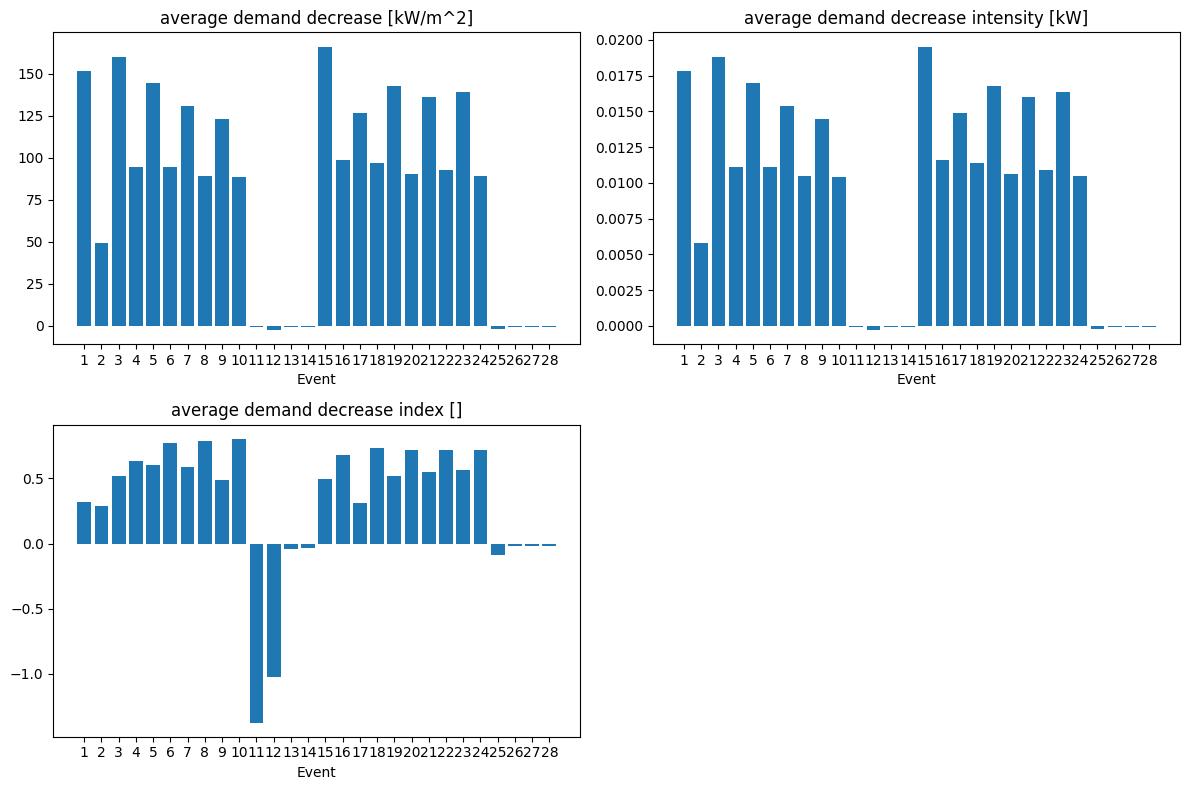

In [ ]:
import numpy as np

csv_file = f'results/kpis_{control}_{control_configuration_scenario}.csv'

# Check if the CSV file exists
if not os.path.exists(csv_file):
    # Create a new DataFrame with the first column as 'kpi'
    df_kpi = pd.DataFrame(columns=['kpi'])
    df_kpi.to_csv(csv_file, index=False)
else:
    # Read the existing CSV file
    df_kpi = pd.read_csv(csv_file)

if all(inner_list for inner_list in values_list_shed):
    # Create a dictionary to store the KPIs and their corresponding averages
    kpi_averages = {}

    # Plot results
    kpis = [v[0] for v in values_list_shed[0]]
   
    column_count_limit = 2
    row_count = math.ceil(len(kpis)/column_count_limit)
    column_count = min(column_count_limit, len(kpis))
    fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
    daily_avg_values = []
    for ax in fig.axes[len(kpis):]:
        fig.delaxes(ax)

    for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
        values = [v[i][2] for v in values_list_shed]
        units = [v[i][1] for v in values_list_shed]

        if isinstance(values[0], float):
            x = list(range(len(shed_signal_timestamps)))
            average = sum(values) / len(shed_signal_timestamps)
            print(f"The average for {kpi} is {average:.4f}")
            ax.bar(x, values)
            ax.set_xlabel('Event')

            kpi_averages[kpi] = average

            # Set custom x-labels
            x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels)
        
        else:
            # Calculate the average of the values
            avg_values = np.mean(values, axis=0)
            average = sum(avg_values) / len(avg_values)
            print(f"The average for {kpi} is {average:.2f}")
            
            kpi_averages[kpi] = average            

            for j, v in enumerate(values):
                ax.plot(v, alpha=0.2)
            ax.plot(avg_values, label='Daily average', linewidth=2)
            ax.set_xlabel('Day')
            ax.legend(loc='upper left')  

        ax.set_title(kpi + ' [' + units[0] +']')

    print(kpi_averages)

    # Ensure the testcase_identifier column exists in the DataFrame
    if testcase_identifier not in df_kpi.columns:
        df_kpi[testcase_identifier] = np.nan

    # Update the DataFrame with the KPI values
    for kpi, average in kpi_averages.items():
        if kpi in df_kpi['kpi'].values:
            # Update the existing KPI row
            df_kpi.loc[df_kpi['kpi'] == kpi, testcase_identifier] = average
        else:
            # Add a new row for the new KPI
            new_row = pd.DataFrame({'kpi': [kpi], testcase_identifier: [average]})
            df_kpi = pd.concat([df_kpi, new_row], ignore_index=True)

    print(df_kpi)
    # Save the updated DataFrame to the CSV file
    df_kpi.to_csv(csv_file, index=False)

    plt.tight_layout()

    png_file_path = os.path.join(path_to_dataset, f'shed_kpis.png')
    plt.savefig(png_file_path)

    plt.show()

In [ ]:
values_list_shift = []

for s, e in shift_signal_timestamps:
    values = []
    print(s, e )
    
    if load_shifting.AverageDemandIncrease.NAME in suitable_kpis:
        # load_shifting
        values.append((
            load_shifting.AverageDemandIncrease.NAME,
            load_shifting.AverageDemandIncrease.info()["unit"],
            load_shifting.AverageDemandIncrease.calculate(
                data.baseline_power_profile.tolist(),
                data.flexible_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))

    if load_shifting.AverageDemandIncreaseIntensity.NAME in suitable_kpis:
        # load_shifting
        values.append((
            load_shifting.AverageDemandIncreaseIntensity.NAME,
            load_shifting.AverageDemandIncreaseIntensity.info()["unit"],
            (load_shifting.AverageDemandIncreaseIntensity.calculate(
                data.baseline_power_profile.tolist(),
                data.flexible_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
                #floor_area=floor_area,
        ))/floor_area))

    if load_shifting.AverageDemandIncreaseIndex.NAME in suitable_kpis:
        # load_shifting
        values.append((
            load_shifting.AverageDemandIncreaseIndex.NAME,
            load_shifting.AverageDemandIncreaseIndex.info()["unit"],
            load_shifting.AverageDemandIncreaseIndex.calculate(
                data.baseline_power_profile.tolist(),
                data.flexible_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
    
    values_list_shift.append(values)

print(values_list_shift)

1970-01-18 04:00:00 1970-01-18 06:59:59
1970-01-18 14:00:00 1970-01-18 16:59:59
1970-01-19 04:00:00 1970-01-19 06:59:59
1970-01-19 14:00:00 1970-01-19 16:59:59
1970-01-20 04:00:00 1970-01-20 06:59:59
1970-01-20 14:00:00 1970-01-20 16:59:59
1970-01-21 04:00:00 1970-01-21 06:59:59
1970-01-21 14:00:00 1970-01-21 16:59:59
1970-01-22 04:00:00 1970-01-22 06:59:59
1970-01-22 14:00:00 1970-01-22 16:59:59
[[('average demand increase', 'kW', np.float64(283.7470438731627)), ('average demand increase intensity', 'kW/m^2', np.float64(0.03338200516154855)), ('average demand increase index', '', np.float64(44.356152202033776))], [('average demand increase', 'kW', np.float64(-0.8505834418754171)), ('average demand increase intensity', 'kW/m^2', np.float64(-0.0001000686402206373)), ('average demand increase index', '', np.float64(-0.007564916239831798))], [('average demand increase', 'kW', np.float64(276.40634223672805)), ('average demand increase intensity', 'kW/m^2', np.float64(0.03251839320432095)),

The average for average demand increase is 84.1399
The average for average demand increase intensity is 0.0099
The average for average demand increase index is 14.8082
{'average demand increase': np.float64(84.13986067091477), 'average demand increase intensity': np.float64(0.009898807137754675), 'average demand increase index': np.float64(14.808160004180857)}
                                           kpi          b1         b2  \
0                      average demand decrease    0.268030   1.685148   
1            average demand decrease intensity    0.005584   0.008777   
2                average demand decrease index    0.422900        NaN   
3                      average demand increase    0.007923   0.213027   
4            average demand increase intensity    0.000165   0.001110   
5                average demand increase index    0.050881        NaN   
6                        average power rebound    0.048849   0.516543   
7                  average power rebound index  188.3

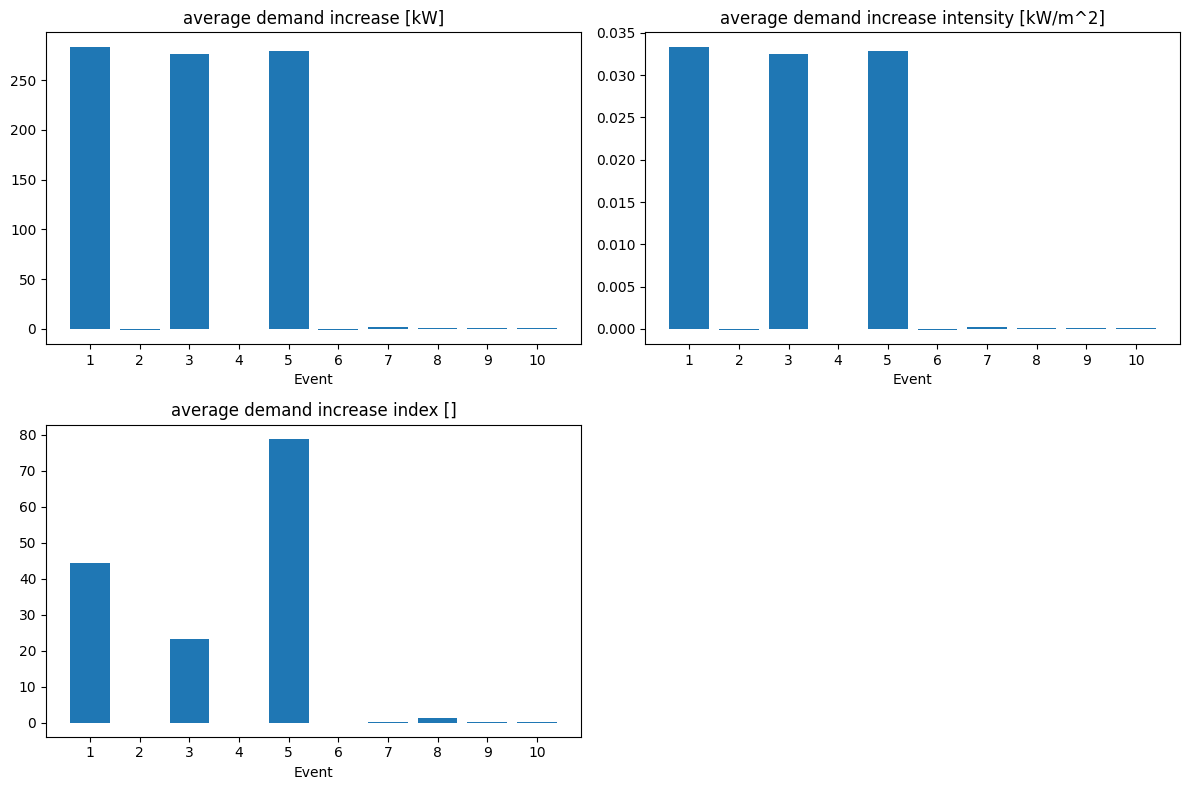

In [ ]:
import numpy as np

if all(inner_list for inner_list in values_list_shift):
    # Create a dictionary to store the KPIs and their corresponding averages
    kpi_averages = {}

    # Plot results
    kpis = [v[0] for v in values_list_shift[0]]
   
    column_count_limit = 2
    row_count = math.ceil(len(kpis)/column_count_limit)
    column_count = min(column_count_limit, len(kpis))
    fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
    daily_avg_values = []
    for ax in fig.axes[len(kpis):]:
        fig.delaxes(ax)

    for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
        values = [v[i][2] for v in values_list_shift]
        units = [v[i][1] for v in values_list_shift]

        if isinstance(values[0], float):
            x = list(range(len(shift_signal_timestamps)))
            average = sum(values) / len(shift_signal_timestamps)
            print(f"The average for {kpi} is {average:.4f}")
            ax.bar(x, values)
            ax.set_xlabel('Event')

            kpi_averages[kpi] = average

            # Set custom x-labels
            x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels)
        
        else:
            # Calculate the average of the values
            avg_values = np.mean(values, axis=0)
            average = sum(avg_values) / len(avg_values)
            print(f"The average for {kpi} is {average:.2f}")
            
            kpi_averages[kpi] = average            

            for j, v in enumerate(values):
                ax.plot(v, alpha=0.2)
            ax.plot(avg_values, label='Daily average', linewidth=2)
            ax.set_xlabel('Day')
            ax.legend(loc='upper left')  

        ax.set_title(kpi + ' [' + units[0] +']')

    print(kpi_averages)

    # Ensure the testcase_identifier column exists in the DataFrame
    if testcase_identifier not in df_kpi.columns:
        df_kpi[testcase_identifier] = np.nan

    # Update the DataFrame with the KPI values
    for kpi, average in kpi_averages.items():
        if kpi in df_kpi['kpi'].values:
            # Update the existing KPI row
            df_kpi.loc[df_kpi['kpi'] == kpi, testcase_identifier] = average
        else:
            # Add a new row for the new KPI
            new_row = pd.DataFrame({'kpi': [kpi], testcase_identifier: [average]})
            df_kpi = pd.concat([df_kpi, new_row], ignore_index=True)

    print(df_kpi)
    # Save the updated DataFrame to the CSV file
    df_kpi.to_csv(csv_file, index=False)

    plt.tight_layout()

    png_file_path = os.path.join(path_to_dataset, f'shift_kpis.png')
    plt.savefig(png_file_path)

    plt.show()

In [ ]:
values_list_rebound = []

for s, e in rebound_signal_timestamps:
    values = []
    print(s, e )


    if peak_power_or_energy_rebound.AveragePowerRebound.NAME in suitable_kpis:
        # peak_power_or_energy_rebound
        values.append((
            peak_power_or_energy_rebound.AveragePowerRebound.NAME,
            peak_power_or_energy_rebound.AveragePowerRebound.info()["unit"],
            peak_power_or_energy_rebound.AveragePowerRebound.calculate(
                data.baseline_power_profile.tolist(),
                data.flexible_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
   
    if peak_power_or_energy_rebound.AveragePowerReboundIndex.NAME in suitable_kpis:
        # peak_power_or_energy_rebound
        values.append((
            peak_power_or_energy_rebound.AveragePowerReboundIndex.NAME,
            peak_power_or_energy_rebound.AveragePowerReboundIndex.info()["unit"],
            peak_power_or_energy_rebound.AveragePowerReboundIndex.calculate(
                data.baseline_power_profile.tolist(),
                data.flexible_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
    
    if peak_power_or_energy_rebound.AveragePowerReboundIntensity.NAME in suitable_kpis:
        # peak_power_or_energy_rebound
        values.append((
            peak_power_or_energy_rebound.AveragePowerReboundIntensity.NAME,
            peak_power_or_energy_rebound.AveragePowerReboundIntensity.info()["unit"],
            (peak_power_or_energy_rebound.AveragePowerReboundIntensity.calculate(
                data.baseline_power_profile.tolist(),
                data.flexible_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        ))/floor_area))
    values_list_rebound.append(values)    


print(values_list_rebound)

1970-01-09 12:00:00 1970-01-09 13:59:59
1970-01-09 19:00:00 1970-01-09 20:59:59
1970-01-10 12:00:00 1970-01-10 13:59:59
1970-01-10 19:00:00 1970-01-10 20:59:59
1970-01-11 12:00:00 1970-01-11 13:59:59
1970-01-11 19:00:00 1970-01-11 20:59:59
1970-01-12 12:00:00 1970-01-12 13:59:59
1970-01-12 19:00:00 1970-01-12 20:59:59
1970-01-13 12:00:00 1970-01-13 13:59:59
1970-01-13 19:00:00 1970-01-13 20:59:59
1970-01-14 12:00:00 1970-01-14 13:59:59
1970-01-14 19:00:00 1970-01-14 20:59:59
1970-01-15 12:00:00 1970-01-15 13:59:59
1970-01-15 19:00:00 1970-01-15 20:59:59
1970-01-16 12:00:00 1970-01-16 13:59:59
1970-01-16 19:00:00 1970-01-16 20:59:59
1970-01-17 12:00:00 1970-01-17 13:59:59
1970-01-17 19:00:00 1970-01-17 20:59:59
1970-01-18 12:00:00 1970-01-18 13:59:59
1970-01-18 19:00:00 1970-01-18 20:59:59
1970-01-19 12:00:00 1970-01-19 13:59:59
1970-01-19 19:00:00 1970-01-19 20:59:59
1970-01-20 12:00:00 1970-01-20 13:59:59
1970-01-20 19:00:00 1970-01-20 20:59:59
1970-01-21 12:00:00 1970-01-21 13:59:59


The average for average power rebound is 1.1476
The average for average power rebound index is -0.1271
{'average power rebound': np.float64(1.1476046524095385), 'average power rebound index': np.float64(-0.1270901168306689)}
                                           kpi          b1         b2  \
0                      average demand decrease    0.268030   1.685148   
1            average demand decrease intensity    0.005584   0.008777   
2                average demand decrease index    0.422900        NaN   
3                      average demand increase    0.007923   0.213027   
4            average demand increase intensity    0.000165   0.001110   
5                average demand increase index    0.050881        NaN   
6                        average power rebound    0.048849   0.516543   
7                  average power rebound index  188.359702   0.663643   
8                    flexibility savings index    7.812993  13.218134   
9            energy savings of demand respons

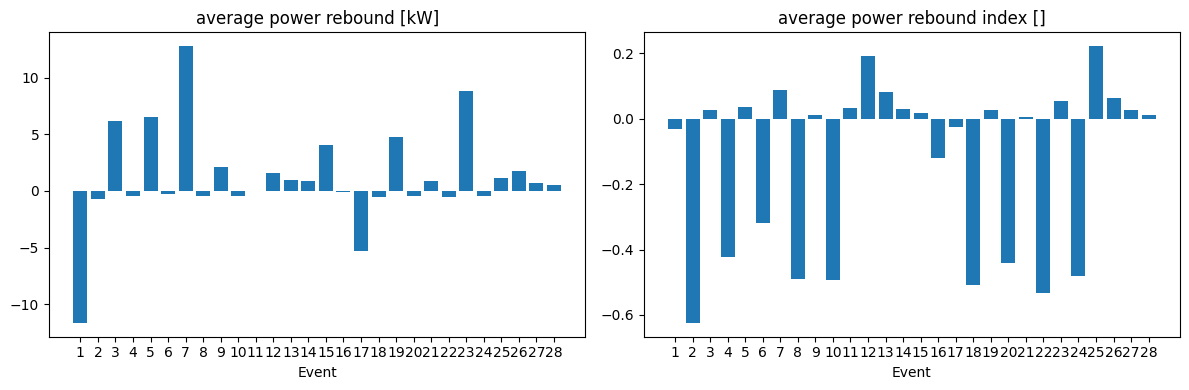

In [ ]:
import numpy as np

if all(inner_list for inner_list in values_list_rebound):
    # Create a dictionary to store the KPIs and their corresponding averages
    kpi_averages = {}

    # Plot results
    kpis = [v[0] for v in values_list_rebound[0]]
   
    column_count_limit = 2
    row_count = math.ceil(len(kpis)/column_count_limit)
    column_count = min(column_count_limit, len(kpis))
    fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
    daily_avg_values = []
    for ax in fig.axes[len(kpis):]:
        fig.delaxes(ax)

    for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
        values = [v[i][2] for v in values_list_rebound]
        units = [v[i][1] for v in values_list_rebound]

        if isinstance(values[0], float):
            x = list(range(len(rebound_signal_timestamps)))
            average = sum(values) / len(rebound_signal_timestamps)
            print(f"The average for {kpi} is {average:.4f}")
            ax.bar(x, values)
            ax.set_xlabel('Event')

            kpi_averages[kpi] = average

            # Set custom x-labels
            x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels)
        
        else:
            # Calculate the average of the values
            avg_values = np.mean(values, axis=0)
            average = sum(avg_values) / len(avg_values)
            print(f"The average for {kpi} is {average:.2f}")
            
            kpi_averages[kpi] = average            

            for j, v in enumerate(values):
                ax.plot(v, alpha=0.2)
            ax.plot(avg_values, label='Daily average', linewidth=2)
            ax.set_xlabel('Day')
            ax.legend(loc='upper left')  

        ax.set_title(kpi + ' [' + units[0] +']')

    print(kpi_averages)

    # Ensure the testcase_identifier column exists in the DataFrame
    if testcase_identifier not in df_kpi.columns:
        df_kpi[testcase_identifier] = np.nan

    # Update the DataFrame with the KPI values
    for kpi, average in kpi_averages.items():
        if kpi in df_kpi['kpi'].values:
            # Update the existing KPI row
            df_kpi.loc[df_kpi['kpi'] == kpi, testcase_identifier] = average
        else:
            # Add a new row for the new KPI
            new_row = pd.DataFrame({'kpi': [kpi], testcase_identifier: [average]})
            df_kpi = pd.concat([df_kpi, new_row], ignore_index=True)

    print(df_kpi)
    # Save the updated DataFrame to the CSV file
    df_kpi.to_csv(csv_file, index=False)

    plt.tight_layout()

    png_file_path = os.path.join(path_to_dataset, f'rebound_kpis.png')
    plt.savefig(png_file_path)

    plt.show()

In [ ]:

values_list_evaluation = []

for s, e in evaluation_timestamps:
    
    values = []
    print(s, e )
    
    if demand_response_costs_or_savings.FlexibilitySavingsIndex.NAME in suitable_kpis:
        # demand_response_costs_or_savings
        values.append((
            demand_response_costs_or_savings.FlexibilitySavingsIndex.NAME,
            demand_response_costs_or_savings.FlexibilitySavingsIndex.info()["unit"],
            100*(demand_response_costs_or_savings.FlexibilitySavingsIndex.calculate(
                data_price_merge.baseline_cost_profile.tolist(),
                data_price_merge.flexible_cost_profile.tolist(),
                timestamps=data_price_merge.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        ))))


        data['timestamp'] = pd.to_datetime(data['timestamp'])  # Convert timestamp to datetime if not already

        data.set_index('timestamp', inplace=True)
        display(data.head())

        data_resampled = data.resample('1H').mean()

        data.reset_index(inplace=True)
        data_resampled.reset_index(inplace=True)
        display(data_resampled.head())

    if demand_response_energy_efficiency.EnergySavingsOfDemandResponse.NAME in suitable_kpis:
        # demand_response_energy_efficiency

        values.append((
            demand_response_energy_efficiency.EnergySavingsOfDemandResponse.NAME,
            demand_response_energy_efficiency.EnergySavingsOfDemandResponse.info()["unit"],
            demand_response_energy_efficiency.EnergySavingsOfDemandResponse.calculate(
                data_resampled.baseline_power_profile.tolist(),
                data_resampled.flexible_power_profile.tolist(),
                timestamps=data_resampled.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))

    
    if demand_response_energy_efficiency.NetBuildingConsumptionChangePercentage.NAME in suitable_kpis:
        # demand_response_energy_efficiency

        values.append((
            demand_response_energy_efficiency.NetBuildingConsumptionChangePercentage.NAME,
            demand_response_energy_efficiency.NetBuildingConsumptionChangePercentage.info()["unit"],
            demand_response_energy_efficiency.NetBuildingConsumptionChangePercentage.calculate(
                data_resampled.baseline_power_profile.tolist(),
                data_resampled.flexible_power_profile.tolist(),
                timestamps=data_resampled.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))


    if peak_power_shedding.PeakPowerReduction.NAME in suitable_kpis:
        # Peak power shedding
        values.append((
            peak_power_shedding.PeakPowerReduction.NAME, 
            peak_power_shedding.PeakPowerReduction.info()["unit"],
            peak_power_shedding.PeakPowerReduction.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                timestamps=data.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))

    if thermal_column in data.columns:

        if peak_power_shedding.PeakPowerReduction.NAME in suitable_kpis:
            # Peak power shedding
            values.append((
                peak_power_shedding.PeakPowerReduction.NAME, 
                peak_power_shedding.PeakPowerReduction.info()["unit"],
                peak_power_shedding.PeakPowerReduction.calculate(
                    data.baseline_thermal_power_profile.tolist(),
                    data.flexible_thermal_power_profile.tolist(),
                    timestamps=data.timestamp.tolist(),
                    evaluation_start_timestamp=s,
                    evaluation_end_timestamp=e,
            )))


    values_list_evaluation.append(values)
print(values_list_evaluation)

1970-01-09 00:00:00 1970-01-22 23:59:59


,baseline_electric_power_profile,flexible_electric_power_profile,baseline_thermal_power_profile,flexible_thermal_power_profile,baseline_power_profile,flexible_power_profile
timestamp,,,,,,
1970-01-09 00:00:00,0.435272,0.435273,31.222881,31.224336,31.658153,31.659609
1970-01-09 00:15:00,0.435551,0.435548,31.575014,31.571266,32.010565,32.006814
1970-01-09 00:30:00,0.435632,0.435635,31.675215,31.680059,32.110846,32.115694
1970-01-09 00:45:00,0.436010,0.436006,32.152734,32.148246,32.588744,32.584252
1970-01-09 01:00:00,0.436015,0.436017,32.156895,32.159728,32.592910,32.595745


C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\2708694118.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample('1H').mean()


,timestamp,baseline_electric_power_profile,flexible_electric_power_profile,baseline_thermal_power_profile,flexible_thermal_power_profile,baseline_power_profile,flexible_power_profile
0,1970-01-09 00:00:00,0.435616,0.435616,31.656461,31.655977,32.092077,32.091592
1,1970-01-09 01:00:00,0.436378,0.436378,32.613665,32.614521,33.050043,33.050899
2,1970-01-09 02:00:00,0.437150,0.437149,33.582907,33.582680,34.020056,34.019830
3,1970-01-09 03:00:00,0.437507,0.437506,34.028172,34.027713,34.465679,34.465220
4,1970-01-09 04:00:00,0.437679,0.860362,34.245518,414.890714,34.683197,415.751076


[[('flexibility savings index', '', np.float64(0.9064134439118354)), ('energy savings of demand response', '(kW*h)', np.float64(2420.608712455647)), ('net building consumption change percentage', '', np.float64(-8.146976509722617)), ('peak power reduction', 'kW', np.float64(-0.00029760626699726345)), ('peak power reduction', 'kW', np.float64(-40.43459760723272))]]


The average for flexibility savings index is 0.9064
The average for energy savings of demand response is 2420.6087
The average for net building consumption change percentage is -8.1470
The average for peak power reduction is -0.0003
The average for peak power reduction is -40.4346
{'flexibility savings index': np.float64(0.9064134439118354), 'energy savings of demand response': np.float64(2420.608712455647), 'net building consumption change percentage': np.float64(-8.146976509722617), 'peak power reduction': np.float64(-40.43459760723272)}
                                           kpi          b1         b2  \
0                      average demand decrease    0.268030   1.685148   
1            average demand decrease intensity    0.005584   0.008777   
2                average demand decrease index    0.422900        NaN   
3                      average demand increase    0.007923   0.213027   
4            average demand increase intensity    0.000165   0.001110   
5               

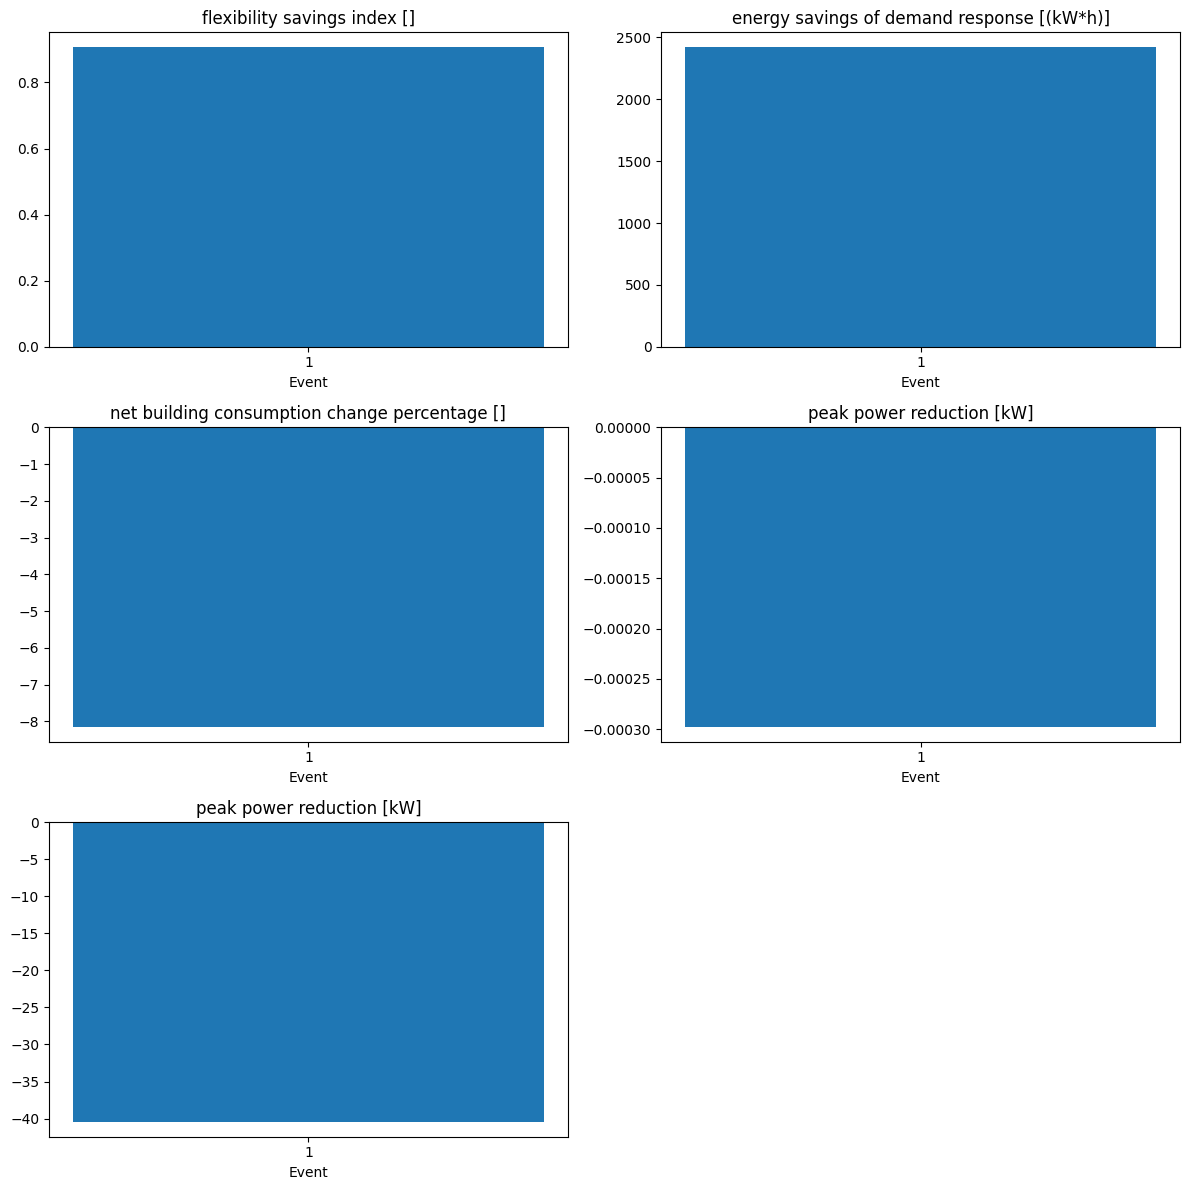

In [ ]:
import numpy as np

if all(inner_list for inner_list in values_list_evaluation):
    # Create a dictionary to store the KPIs and their corresponding averages
    kpi_averages = {}

    # Plot results
    kpis = [v[0] for v in values_list_evaluation[0]]
   
    column_count_limit = 2
    row_count = math.ceil(len(kpis)/column_count_limit)
    column_count = min(column_count_limit, len(kpis))
    fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
    daily_avg_values = []
    for ax in fig.axes[len(kpis):]:
        fig.delaxes(ax)

    for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
        values = [v[i][2] for v in values_list_evaluation]
        units = [v[i][1] for v in values_list_evaluation]

        if isinstance(values[0], float):
            x = list(range(len(evaluation_timestamps)))
            average = sum(values) / len(evaluation_timestamps)
            print(f"The average for {kpi} is {average:.4f}")
            ax.bar(x, values)
            ax.set_xlabel('Event')

            kpi_averages[kpi] = average

            # Set custom x-labels
            x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels)
        
        else:
            # Calculate the average of the values
            avg_values = np.mean(values, axis=0)
            average = sum(avg_values) / len(avg_values)
            print(f"The average for {kpi} is {average:.2f}")
            
            kpi_averages[kpi] = average            

            for j, v in enumerate(values):
                ax.plot(v, alpha=0.2)
            ax.plot(avg_values, label='Daily average', linewidth=2)
            ax.set_xlabel('Day')
            ax.legend(loc='upper left')  

        ax.set_title(kpi + ' [' + units[0] +']')

    print(kpi_averages)

    # Ensure the testcase_identifier column exists in the DataFrame
    if testcase_identifier not in df_kpi.columns:
        df_kpi[testcase_identifier] = np.nan

    # Update the DataFrame with the KPI values
    for kpi, average in kpi_averages.items():
        if kpi in df_kpi['kpi'].values:
            # Update the existing KPI row
            df_kpi.loc[df_kpi['kpi'] == kpi, testcase_identifier] = average
        else:
            # Add a new row for the new KPI
            new_row = pd.DataFrame({'kpi': [kpi], testcase_identifier: [average]})
            df_kpi = pd.concat([df_kpi, new_row], ignore_index=True)

    print(df_kpi)
    # Save the updated DataFrame to the CSV file
    df_kpi.to_csv(csv_file, index=False)

    plt.tight_layout()

    png_file_path = os.path.join(path_to_dataset, f'generic_kpis.png')
    plt.savefig(png_file_path)

    plt.show()

# Visualize selected KPIs for all buildings 

,kpi,b1,b2,b3
0,average demand decrease,0.268030,1.685148,81.966845
1,average demand decrease intensity,0.005584,0.008777,0.009643
2,average demand decrease index,0.422900,NaN,0.327455
3,average demand increase,0.007923,0.213027,84.139861
4,average demand increase intensity,0.000165,0.001110,0.009899
5,average demand increase index,0.050881,NaN,14.808160
6,average power rebound,0.048849,0.516543,1.147605
7,average power rebound index,188.359702,0.663643,-0.127090
8,flexibility savings index,7.812993,13.218134,0.906413
9,energy savings of demand response,8.820126,77.296487,2420.608712


C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3675090499.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_filtered.columns, y=df_filtered.loc[kpi], ax=axes[i], palette="viridis")
C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3675090499.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_filtered.columns, y=df_filtered.loc[kpi], ax=axes[i], palette="viridis")
C:\Users\Flavinha\AppData\Local\Temp\ipykernel_3504\3675090499.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_filtered.columns, y=df_filtered.loc[kp

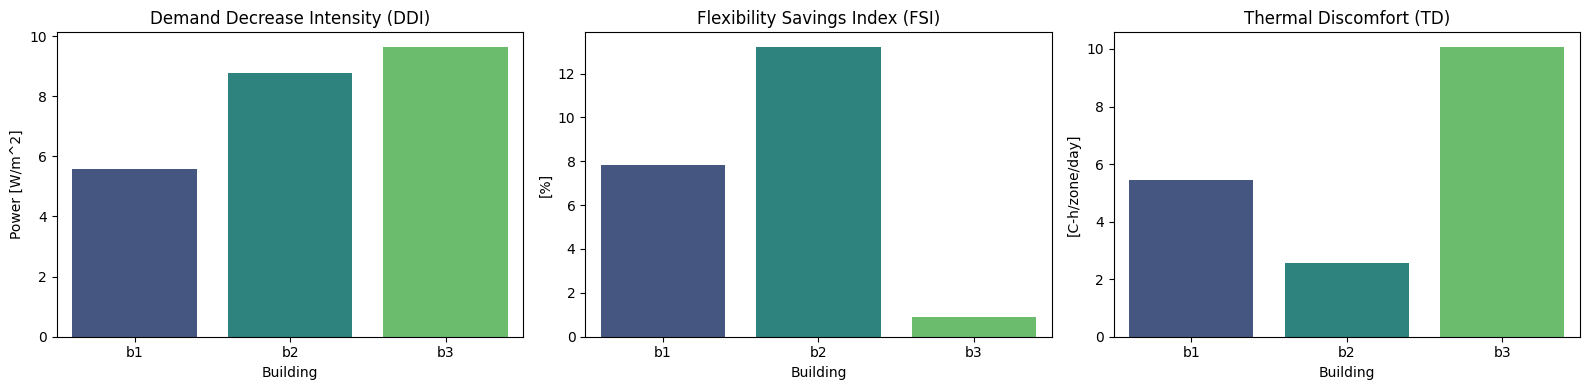

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_boptest_kpis = pd.read_csv(os.path.join(path_to_dataset, 'kpis_con.csv'))

kpi_name = 'tdis_tot'
tdis_tot_value = df_boptest_kpis['tdis_tot'].iloc[0]/14 # for 2-week simulation boptest scenarios 

if kpi_name in df_kpi['kpi'].values:
    # Update the existing KPI row
    df_kpi.loc[df_kpi['kpi'] == kpi_name, testcase_identifier] = tdis_tot_value
else:
    # Add a new row for the new KPI
    new_row = pd.DataFrame({'kpi': [kpi_name], testcase_identifier: [tdis_tot_value]})
    df_kpi = pd.concat([df_kpi, new_row], ignore_index=True)
    
df_kpi.to_csv(csv_file, index=False)
display(df_kpi)

# Verify column names
#print(df_kpi.columns)

# Verify KPI names in the dataframe
#print(df_kpi['kpi'].unique())

# Extract data for the specified KPIs
kpis_of_interest = [
    'average demand decrease intensity',
    'flexibility savings index',
    'tdis_tot'
]

df_filtered = df_kpi[df_kpi['kpi'].isin(kpis_of_interest)].set_index('kpi')

df_filtered.loc['average demand decrease intensity'] *= 1000

# Display the filtered dataframe
#display(df_filtered)

# Titles and y-axis labels mapping
titles_mapping = {
    'average demand decrease intensity': 'Demand Decrease Intensity (DDI)',
    'flexibility savings index': 'Flexibility Savings Index (FSI)',
    'tdis_tot': 'Thermal Discomfort (TD)'
}

yaxis_labels_mapping = {
    'average demand decrease intensity': 'Power [W/m^2]',
    'flexibility savings index': '[%]',
    'tdis_tot': '[C-h/zone/day]'
}

# Create a figure with three bar plots in a row without bar values
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, kpi in enumerate(kpis_of_interest):
    #print(i, kpi)
    sns.barplot(x=df_filtered.columns, y=df_filtered.loc[kpi], ax=axes[i], palette="viridis")
    axes[i].set_title(titles_mapping[kpi])
    axes[i].set_xlabel('Building')
    axes[i].set_ylabel(yaxis_labels_mapping[kpi])

plt.tight_layout()
plt.savefig(f'results/kpis_{control}{control_configuration_scenario}.png')

plt.show()

